May 2017, revised in 2019


Zhanna Zhanabekova

IPython Notebook #1 of 2: Load and explore data. Transform variables.

**The goal of this project** is to predict the outcome of credit card-related consumer complaints filed with the Consumer Financial Protection Bureau (CFPB). Here, an outcome could result in monetary relief or be settled otherwise.



In [1]:
# Import useful packages
import pandas as pd
import numpy as np
import csv
import pickle
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Set up directory path and load the CFPB data
directory = '[[enter directory path]]'
df =pd.read_csv(directory+ 'Consumer_Complaints_loaded_March20_2017.csv', \
                header = 0, sep = ',', dtype = 'str')
# NOTE: This file was too big to save on Github so I posted a smaller version of it with 
# credit card complaints only - please see below

# List column names
print(df.columns)
print()

# Print the number of observations
print('N = ', df.shape[0])
print()

# Examine the first 5 rows of data (transposed)
df.head().T

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

N =  738832



,0,1,2,3,4
Date received,07/29/2013,07/29/2013,07/29/2013,07/29/2013,07/29/2013
Product,Consumer Loan,Bank account or service,Bank account or service,Bank account or service,Mortgage
Sub-product,Vehicle loan,Checking account,Checking account,Checking account,Conventional fixed mortgage
Issue,Managing the loan or lease,Using a debit or ATM card,"Account opening, closing, or management",Deposits and withdrawals,"Loan servicing, payments, escrow account"
Sub-issue,NaN,NaN,NaN,NaN,NaN
Consumer complaint narrative,NaN,NaN,NaN,NaN,NaN
Company public response,NaN,NaN,NaN,NaN,NaN
Company,Wells Fargo & Company,Wells Fargo & Company,Santander Bank US,Wells Fargo & Company,Franklin Credit Management
State,VA,CA,NY,GA,CT
ZIP code,24540,95992,10065,30084,06106


## Outcome variable: *Company response to consumer*

In [4]:
# Tabulate outcome variable 'Company response to consumer'
df['Company response to consumer'].value_counts()


Closed with explanation            549671
Closed with non-monetary relief     91580
Closed with monetary relief         49392
Closed without relief               17863
Closed                              17004
Closed with relief                   5298
Untimely response                    4037
In progress                          3987
Name: Company response to consumer, dtype: int64

In [5]:
# Drop "In progress" observations
df = df[df['Company response to consumer'] != 'In progress']


In [6]:
# Generate a binary outcome variable - closed with monetary relief (1) or otherwise (0)
df['Y'] = np.where(df['Company response to consumer'] == 'Closed with monetary relief', 1,0)


In [7]:
#Select only credit card-related complaints
df = df[df.Product == 'Credit card']
print('N = ', df.shape[0])


N =  85835


In [8]:
# Tabulate the binary outcome variable (#):
print(df.Y.value_counts())
print()

# Tabulate the binary outcome variable (%):
print(df.Y.value_counts()/df.shape[0])
print()

# Drop 'Company response to consumer' variable
del df['Company response to consumer']

0    68036
1    17799
Name: Y, dtype: int64

0    0.792637
1    0.207363
Name: Y, dtype: float64



In [9]:
# Export the smaller version of the CFPB dataset with credit card complaints only to csv
df.to_csv(directory+'Consumer_Complaints_loaded_March20_2017_CREDIT_CARDS.csv')


## Data clean-up and feature engineering

In [12]:
# Identify variables with missing values 
## Note that 'Sub-product' and 'Sub-issue' have all values missing (drop these below)
print('VARIABLES WITH MISSING VALUES: ')
print()
for i in df.columns:
    count_nulls = df[i].isna().sum() 
    if count_nulls >0 and count_nulls == df.shape[0]:
        print('{}, {}, ALL NULLS'.format(i, df[i].isna().sum()))
    elif count_nulls>0:
        print('{},'.format(i), df[i].isna().sum())
        

VARIABLES WITH MISSING VALUES: 

Sub-product, 85835, ALL NULLS
Sub-issue, 85835, ALL NULLS
Consumer complaint narrative, 69040
Company public response, 66721
State, 715
ZIP code, 716
Tags, 72860
Consumer consent provided?, 57400
Consumer disputed?, 3307


In [13]:
# Check that the Complaint ID is unique. Drop it (below).
print(df['Complaint ID'].nunique() == df.shape[0])


True


### Variable *Issue*

In [14]:
# Tabulate 'Issue' by outcome (Y)
pd.crosstab(index = df.Issue, columns = df.Y, 
            normalize = 'index').sort_values(by=1, ascending=False)


Y,0,1
Issue,,
Late fee,0.476665,0.523335
Other fee,0.550972,0.449028
Cash advance fee,0.609375,0.390625
Overlimit fee,0.657143,0.342857
Billing disputes,0.686536,0.313464
Billing statement,0.711644,0.288356
Balance transfer fee,0.728972,0.271028
Convenience checks,0.734266,0.265734
Transaction issue,0.735769,0.264231


It appears that monetary compensation is more likely to be granted for fee- and billing-related complaints (~30-50% of the time) than for privacy or credit determination complaints (~2-3%). Overall, 'Issue' appears to be an important factor in predicting monetary resolution. Hence, I keep all 'Issue' categories without introducing any higher-level groupings and set 'Other' to be the excluded (baseline) category in regressions.


In [15]:
# Create indicator / dummy variables for all 'Issue' categories 
# Let 'Other' be the excluded category in regressions (i.e., drop it)
df_Issue = pd.get_dummies(df['Issue']) 
df_Issue = df_Issue.drop(['Other'], axis=1)
df = pd.concat([df, df_Issue], axis=1)


### Variable *Consumer complaint narrative*

In [16]:
# Create an indicator variable for the presense of a complaint narrative 
print('Number of complaints without a narrative: ', 
      df['Consumer complaint narrative'].isna().sum())
print()

df['Is_narrative'] = np.where(df['Consumer complaint narrative'].notnull(), 1, 0)


Number of complaints without a narrative:  69040



In [17]:
# Tabulate indicator variable for 'Consumer complaint narrative' by outcome (Y)
pd.crosstab(index = df.Is_narrative, 
            columns = df.Y, normalize = 'index').sort_values(by=1, ascending=False)


Y,0,1
Is_narrative,,
1,0.767133,0.232867
0,0.798841,0.201159


Complaints *with a narrative* are slightly more likely to have monetary relief.

### Variable *Company*

In [18]:
# Variable 'Company' has 400+ categories
# Create dummy variables for the companies with at least 3% of complaints in the dataset
# and group the rest into "others" (arbitrary)

print('# of companies: ', df.Company.nunique())
print()

#Examine % of complaints for the top 20 companies
tabulate_companies = df.Company.value_counts()/df.shape[0]
print(tabulate_companies[:20])
print()

# Create company indicator / dummy variables
df['Citibank'] = np.where(df.Company == 'Citibank', 1, 0)
df['CapitalOne'] = np.where(df.Company == 'Capital One', 1, 0)
df['JPMorganChase'] = np.where(df.Company == 'JPMorgan Chase & Co.', 1, 0)
df['BoA'] = np.where(df.Company == 'Bank of America', 1, 0)
df['Synchrony'] = np.where(df.Company == 'Synchrony Financial', 1, 0)
df['Amex'] = np.where(df.Company == 'Amex', 1, 0)
df['Discover'] = np.where(df.Company == 'Discover', 1, 0)
df['WellsFargo'] = np.where(df.Company == 'Wells Fargo & Company', 1, 0)
df['Barclays'] = np.where(df.Company == 'Barclays PLC', 1, 0)
# For the purpose of regressions, no need to create an indicator variable for 
# category "others" (the excluded category)


# of companies:  418

Citibank                             0.189480
Capital One                          0.145384
JPMorgan Chase & Co.                 0.116666
Bank of America                      0.102767
Synchrony Financial                  0.098561
Amex                                 0.075261
Discover                             0.047696
Wells Fargo & Company                0.045203
Barclays PLC                         0.038679
U.S. Bancorp                         0.027565
TD Bank US Holding Company           0.014551
USAA Savings                         0.010019
PayPal Holdings, Inc.                0.007736
HSBC North America Holdings Inc.     0.007643
First National Bank of Omaha         0.006571
PNC Bank N.A.                        0.005476
Fifth Third Financial Corporation    0.004497
Navy FCU                             0.003961
Alliance Data Card Services          0.002691
Continental Finance Company, LLC     0.002563
Name: Company, dtype: float64



In [19]:
# Recode the original Company variable slightly and
# tabulate it by outcome (Y)
df['Company_recoded'] = df['Company']

companies = ['Citibank', 'Capital One', 'JPMorgan Chase & Co.','Bank of America', 
             'Synchrony Financial','Amex', 'Discover', 'Wells Fargo & Company', 
             'Barclays PLC']

df.loc[~df.Company.isin(companies), 'Company_recoded'] = 'Other'

# Tabulate recoded Company variable by outcome (Y)
pd.crosstab(index = df['Company_recoded'], 
            columns = df.Y, normalize = 'index').sort_values(by=1, ascending=False)


Y,0,1
Company_recoded,,
Citibank,0.685686,0.314314
Synchrony Financial,0.710520,0.289480
Barclays PLC,0.719277,0.280723
Capital One,0.808799,0.191201
Discover,0.821690,0.178310
Amex,0.833901,0.166099
Wells Fargo & Company,0.836856,0.163144
Other,0.846633,0.153367
Bank of America,0.858293,0.141707


Some companies seem more likely to offer monetary relief (e.g., *Citibank* in 31% of the cases vs *Bank of America* in only 13% of the cases). Below I check whether this may be related to the nature of the filed complains (using variable 'Issue') but there does not appear to be a signficant difference in the distribution of Issues between the two sampled companies, for example. Regardless, we will control for fixed differences across companies when modeling the outcome using companies' dummy variables created above.

In [20]:
# Example: Tabulate this distribution of Issues for 2 companies (for comparison)
pd.crosstab(index = df.Issue,
            columns = df[df.Company.isin(['Citibank', 'Bank of America'])].Company, 
            normalize = 'columns')


Company,Bank of America,Citibank
Issue,,
APR or interest rate,0.053622,0.061485
Advertising and marketing,0.020519,0.029575
Application processing delay,0.003741,0.004857
Arbitration,0.004308,0.003320
Balance transfer,0.015191,0.009530
Balance transfer fee,0.003514,0.001599
Bankruptcy,0.004761,0.003136
Billing disputes,0.167555,0.189621
Billing statement,0.027435,0.042179


### Variable *State*

In [21]:
# Tabulate State by outcome (Y)
tab_state_Y = pd.crosstab(index = df.State, columns = df.Y, 
            normalize = 'index').sort_values(by=1, ascending=False)
tab_state_Y


Y,0,1
State,,
AP,0.666667,0.333333
MP,0.666667,0.333333
VT,0.734694,0.265306
IA,0.751708,0.248292
OR,0.763158,0.236842
WI,0.765422,0.234578
RI,0.767081,0.232919
ME,0.774194,0.225806
ID,0.775758,0.224242


In [22]:
print('Descriptive stats for % of complaints resulting in monetary \
compensation by state: ')
tab_state_Y[1].describe()


Descriptive stats for % of complaints resulting in monetary compensation by state: 


count    62.000000
mean      0.193832
std       0.062104
min       0.000000
25%       0.190401
50%       0.208670
75%       0.215683
max       0.333333
Name: 1, dtype: float64

In [23]:
# Tabulate Y for the NULL values of State
df[df.State.isna()].Y.mean()


0.213986013986014

There seems to be some variation in the likelihood of monetary compensation by state, ranging from 0 to 33%, with both average and median centered at around 20% and standard deviation of 6%. This implies that state dummies are likely to be non-trivial drivers in the predictive model.

In [24]:
# Create dummy variables for all states, inclduing DC, US territories, and military states
# Make State's NULL values the excluded (baseline) category in regressions
df_States = pd.get_dummies(df['State']) 
df = pd.concat([df, df_States], axis=1)

# terrirotires_and_military_states = ['AA', 'AE', 'AP', 'FM', 'GU', 'ND', 'MH',
#'MP', 'PR', 'PW', 'VI']

### Variable *Tags*

In [25]:
# Tabulate variable 'Tags'
print(df.Tags.value_counts(dropna=False)/df.shape[0])
print()

# Create dummy variables for 3 non-null 'Tags' categories 
# Let null values be the excluded category
df_Tags = pd.get_dummies(df['Tags']) 
df = pd.concat([df, df_Tags], axis=1)


NaN                              0.848838
Older American                   0.109466
Servicemember                    0.031129
Older American, Servicemember    0.010567
Name: Tags, dtype: float64



In [26]:
# Tabulate Tags by outcome (Y)
pd.crosstab(index = df['Tags'], 
            columns = df.Y, normalize = 'index').sort_values(by=1, ascending=False)


Y,0,1
Tags,,
Older American,0.765006,0.234994
"Older American, Servicemember",0.801544,0.198456
Servicemember,0.814746,0.185254


In [27]:
# Tabulate Y for the NULL values of Tags
df[df.Tags.isna()].Y.mean()


0.20472138347515784

Older Non-Service Member Americans (who filed ~11% of complaints in the dataset) are more likely to be offered monetary relief than people in other Tags categories.

### Varibale *Consumer consent provided?*

In [28]:
#Tabulate and recode whether the consumer provided consent to share information
print(df['Consumer consent provided?'].value_counts(dropna=False)/df.shape[0])

df['Consent provided'] = np.where(df['Consumer consent provided?'] == 'Consent provided', 1,0)


NaN                     0.668725
Consent provided        0.195666
Consent not provided    0.129912
Other                   0.005697
Name: Consumer consent provided?, dtype: float64


In [29]:
# Tabulate Consent by outcome (Y)
pd.crosstab(index = df['Consent provided'], 
            columns = df.Y, normalize = 'index').sort_values(by=1, ascending=False)


Y,0,1
Consent provided,,
1,0.767133,0.232867
0,0.798841,0.201159


Complainants who provided consent to share their data are slightly more likely to have their credit card complaints resolved with monetary relief.

### Variable *Submitted via*

In [30]:
# Tabulate the method of complaint submission by outcome (Y)
pd.crosstab(index = df['Submitted via'], 
            columns = df.Y, normalize = 'index').sort_values(by=1, ascending=False)


Y,0,1
Submitted via,,
Web,0.782469,0.217531
Fax,0.789535,0.210465
Phone,0.811140,0.188860
Referral,0.811165,0.188835
Postal mail,0.834468,0.165532
Email,0.837209,0.162791


Emailed and mailed credit card complaints have lower rates of resolution with monetary compensation compared with complaints submitted via the CFPB website or fax.

In [31]:
#Tabulate the way the complaint was delivered to the CFPB
print(df['Submitted via'].value_counts(dropna=False)/df.shape[0])

# Create dummy variables for 'Submitted via' categories. Group Postal Mail and Email and 
# treat them as "others" (the excluded category)
df['Submitted_Web'] = np.where(df['Submitted via'] == 'Web', 1,0)
df['Submitted_Fax'] = np.where(df['Submitted via'] == 'Fax', 1,0)
df['Submitted_Phone'] = np.where(df['Submitted via'] == 'Phone', 1,0)
df['Submitted_Referral'] = np.where(df['Submitted via'] == 'Referral', 1,0)


Web            0.687132
Referral       0.166948
Phone          0.075505
Postal mail    0.059894
Fax            0.010019
Email          0.000501
Name: Submitted via, dtype: float64


### Variable *Timely response?*

In [32]:
# Tabulate  'Timely response?'  by outcome (Y)
pd.crosstab(index = df['Timely response?'], 
            columns = df.Y, normalize = 'index').sort_values(by=1, ascending=False)


Y,0,1
Timely response?,,
Yes,0.791552,0.208448
No,0.891026,0.108974


Promptness of company response seems to be an important indicator of whether the credit card complaint would be resolved with monetary compensation - 21% for timely responses vs 11% otherwise.

In [33]:
#Tabulate Timely response variable
print(df['Timely response?'].value_counts(dropna=False)/df.shape[0])

#The majority of company responses are timely. So I recode 'No' values as 1 and 'Yes' as 0
df['Not_timely_response'] = np.where(df['Timely response?']== 'No', 1, 0)


Yes    0.989095
No     0.010905
Name: Timely response?, dtype: float64


### Variable *Year*

Note that there are two time variables - Date the consumer complaint was received by the CFPB and the date the CFPB forwarded it to the company. The two variables are very similar, so I keep 'Date received' and drop 'Date sent to company.'


In [36]:
# Create Year variable from Date received
df['Year'] = df['Date received'].str[6:]

# Tabulate (#)
print(df.Year.value_counts(dropna=False))
print()

# Tabulate (%)
df.Year.value_counts(dropna=False)/df.shape[0]


2016    21063
2015    17301
2012    15355
2014    13973
2013    13107
2017     3776
2011     1260
Name: Year, dtype: int64



2016    0.245389
2015    0.201561
2012    0.178890
2014    0.162789
2013    0.152700
2017    0.043991
2011    0.014679
Name: Year, dtype: float64

In [37]:
# Tabulate  Year  by outcome (Y)
pd.crosstab(index = df['Year'], 
            columns = df.Y, normalize = 'index').sort_values(by=1, ascending=False)


Y,0,1
Year,,
2013,0.754788,0.245212
2014,0.769770,0.230230
2016,0.790058,0.209942
2015,0.799607,0.200393
2017,0.800053,0.199947
2012,0.822664,0.177336
2011,0.999206,0.000794


Years 2013 and 2014 had the highest percentage of monetary resolutions. Note that 2011 seems to be an atypical year because it has few observations and essentially no resolutions with monetary relief. So I drop yar 2011 observations (n=1,260) and set year 2012 as my baseline year in regressions. 

In [38]:
# Create yearly dummies and make 2012 the excluded category
df = df[df.Year != '2011']

df_Year = pd.get_dummies(df['Year'])
df_Year = df_Year.drop(['2012'], axis =1)
df = pd.concat([df, df_Year], axis=1)

### Variable *Month*

In [39]:
# Create Month variable from Date received
df['Month'] = df['Date received'].str[:2]

# Tabulate Month (%)
df.Month.value_counts(dropna=False)/df.shape[0]


02    0.096518
01    0.095537
03    0.086491
08    0.084233
10    0.084044
07    0.082719
09    0.082306
06    0.080426
04    0.078889
05    0.078853
12    0.075873
11    0.074112
Name: Month, dtype: float64

In [40]:
# Tabulate  Month  by outcome (Y)
pd.crosstab(index = df['Month'], 
            columns = df.Y, normalize = 'index').sort_values(by=1, ascending=False)


Y,0,1
Month,,
07,0.760577,0.239423
10,0.764772,0.235228
08,0.775969,0.224031
09,0.777618,0.222382
06,0.777859,0.222141
12,0.779024,0.220976
11,0.784780,0.215220
05,0.805068,0.194932
01,0.805569,0.194431


Seasonality appears important as we observe some degree of variation in monetary resolution rates by month - July 24% vs April 18.6%.

In [41]:
# Create monthly dummy variables
# Let April be the baseline (excluded) category
df_Months = pd.get_dummies(df['Month']) 
df_Months = df_Months.drop(['04'], axis=1)
df = pd.concat([df, df_Months], axis=1)


##  Add American Community Survey (Census) Data

In [42]:
# Number of unique zip codes in the dataset
df['ZIP code'].nunique()

15402

Since there are over 15,000 zip codes, instead of creating that many zip code dummy variables, I add zip code-level socio-economic information from the American Community Survey (ACS) to control for this type of differences across zip codes.

In [43]:
# Load ACS data
socio_econ_data = pd.read_pickle(open(directory+'ACS_census_data.pickle', 'rb'))

# Remove empty space from variable ZIP code
socio_econ_data["ZIP code"] = socio_econ_data["ZIP code"].str.strip()

# Check length of the zip code in ACS data - always 5 digits
socio_econ_data["ZIP code"].str.len().value_counts()

# Check if any non-alphanumeric characters are present
print("Number of non-alphanumeric characters: ", 
      socio_econ_data[socio_econ_data["ZIP code"].str.isalnum()==False].shape[0])
print()

# Check for non-numeric characters in the zip code
print('Alpha characters in the zip code:')
print(socio_econ_data["ZIP code"].str.extract('([A-Z])')[0].value_counts())
print()

# Check if Zip code has null values
print('Number of null values: ', socio_econ_data['ZIP code'].isna().sum())

Number of non-alphanumeric characters:  0

Alpha characters in the zip code:
Series([], Name: 0, dtype: int64)

Number of null values:  0


In [44]:
# CFPB data
# Remove empty space from variable ZIP code
df["ZIP code"] = df["ZIP code"].str.strip()

# Check length of the zip code in the CFPB data - mostly 5 digits
print('Length')
print(df["ZIP code"].str.len().value_counts())
print()

# Check if any non-alphanumeric characters are present
print("Number of non-alphanumeric characters: ", 
      df[df["ZIP code"].str.isalnum()==False].shape[0])
print()

# Check for non-numeric characters in the zip code
print('Alpha characters in the zip code:')
print(df["ZIP code"].str.extract('([A-Z])')[0].value_counts())
print()

# Check if Zip code has null values
print('Number of null values: ', df['ZIP code'].isna().sum())

#ideally want to write a function for the above

Length
5.0    83860
4.0       14
Name: ZIP code, dtype: int64

Number of non-alphanumeric characters:  19

Alpha characters in the zip code:
X    17680
Name: 0, dtype: int64

Number of null values:  701


Note that the ACS (Census) data contains a pretty clean zip code variable that consists of 5 digits. Zip code in the CFPB data, however, has missing values and occasionally contains some non-alphanumeric characters (-) or letter 'X'. This means that I will not be able to add ACS data to some zip codes in the CFPB data. My solution is to fill in missing values with means and create dummy variables that would indicate when the value was missing. Note that the alternative solution of dropping missing values would result in a loss of at least 21% of complaints (=17,680/84,575). 

In [45]:
# All variables available in the ACS (Census) data
socio_econ_data.columns


Index(['ZIP code', 'unemployment_rate', 'Commutes_to_work_drives_alone',
       'Commutes_to_work_carpool', 'Commutes_to_work_public_transport',
       'Mean_travel_time', 'Median_household_income', 'percent_with_earnings',
       'percent_with_social_security', 'percent_with_retirement_income',
       'percent_with_supplementary_security_income',
       'percent_with_cash_public_assistance', 'percent_with_food_stamps_snap',
       'median_earnings_for_worker', 'median_earnings_for_male_worker',
       'median_earnings_for_female_worker',
       'percent_civil_pop_with_health_ins',
       'percent_civil_pop_with_private_health_ins',
       'percent_civil_pop_with_public_health_ins',
       'percent_civil_pop_without_health_ins',
       'percent_below_poverty_families', 'percent_below_poverty_people',
       'percent_below_poverty_under18yo', 'percent_below_poverty_ages18_plus',
       'percent_below_poverty_ages18_64', 'total_pop', 'age_0_19', 'age_20_29',
       'age_30_39', 'age_40_6

Some of the ACS variables listed above are either highly correlated (% of *families* below poverty line and % of *people* below poverty line) or collinear (% of people in various age categories). So below I select only several ACS variables to characterize socio-economic differences across zip codes.

In [46]:
# Select a subset of ACS variables
census_vars = ['ZIP code', 'unemployment_rate', 'Commutes_to_work_drives_alone', 
               'Mean_travel_time', 'Median_household_income', 'percent_with_earnings',
               'percent_civil_pop_without_health_ins', 'percent_below_poverty_families', 
               'median_age', 'age_0_19', 'age_65_plus']
socio_econ_data = socio_econ_data[census_vars]


In [47]:
# Add ACS data to the CFPB data
df = df.merge(socio_econ_data, on = 'ZIP code', how = 'left', indicator = True)
df._merge.value_counts()/df.shape[0] # 25% of observations have no ACS data


both          0.755507
left_only     0.244493
right_only    0.000000
Name: _merge, dtype: float64

In [48]:
# Replace missing ACS data with means
for i in census_vars[1:]:
        
        #create missing value dummies for ACS variables
        df[i+'_missing'] = np.where(df[i].isna(), 1, 0)
        
        # replace missing values with means
        df[i] = df[i].fillna(df[i].mean())

In [49]:
# Examine averages of ACS (Census) variables by outcome (Y)
pd.options.display.float_format = "{:,.1f}".format
df.groupby(['Y']).agg({'unemployment_rate': 'mean',
                      'Commutes_to_work_drives_alone':'mean',
                      'Mean_travel_time':'mean',
                      'Median_household_income':'mean',
                      'percent_with_earnings':'mean',
                      'percent_civil_pop_without_health_ins':'mean',
                      'percent_below_poverty_families':'mean',
                      'median_age':'mean',
                      'age_0_19':'mean',
                      'age_65_plus':'mean'
                      }).T
    

Y,0,1
unemployment_rate,8.0,7.8
Commutes_to_work_drives_alone,73.5,73.5
Mean_travel_time,27.1,27.1
Median_household_income,"66,430.1","67,100.9"
percent_with_earnings,79.2,79.3
percent_civil_pop_without_health_ins,11.5,11.3
percent_below_poverty_families,10.0,9.7
median_age,38.9,39.1
age_0_19,24.6,24.5
age_65_plus,14.5,14.6


The averages of ACS variables across the two categories of our outcome variable appear to be very similar. No significant differences really jump out at this point.

In [50]:
# Generate summary stats for all ACS (Census) variables
df[census_vars].describe().T


,count,mean,std,min,25%,50%,75%,max
unemployment_rate,"84,575.0",7.9,3.3,0.0,6.0,7.9,8.6,100.0
Commutes_to_work_drives_alone,"84,575.0",73.5,15.2,0.0,73.5,75.4,81.9,100.0
Mean_travel_time,"84,575.0",27.1,5.5,6.3,23.7,27.1,29.4,113.5
Median_household_income,"84,575.0","66,571.2","23,730.8","3,479.0","51,079.0","66,571.2","73,856.0","236,500.0"
percent_with_earnings,"84,575.0",79.2,7.4,0.0,77.3,79.2,83.2,100.0
percent_civil_pop_without_health_ins,"84,575.0",11.4,5.7,0.0,7.7,11.4,13.1,100.0
percent_below_poverty_families,"84,575.0",9.9,6.8,0.0,5.3,9.9,11.1,100.0
median_age,"84,575.0",38.9,5.5,15.5,36.0,38.9,41.1,91.8
age_0_19,"84,575.0",24.6,5.0,0.0,23.0,24.6,26.9,91.9
age_65_plus,"84,575.0",14.6,5.7,0.0,11.6,14.6,15.8,100.1


## Drivers of Monetary Relief in Credit Card Complaints

So far, what have we learned about determinants of whether a credit card complaint will be met with monetary relief?

- **Variable "Issue"** definitely seems to be the most important driver. When we tabulated the % of positive outcomes by Issue categories, fee- and billing-related complaints had a very high percentage of positive outcomes compared with complaints related to credit determination, etc. 


- **Companies** also seem to vary a great deal in the way they settle complaints, and preliminary analysis suggests that this is not necessarily entirely related to differences in the mix of credit card complaints handled by different companies. 


- The **State** of complainant's residence seems to matter as the % of positive outcomes by state ranged from 0% to 33%. However, this may be due to states and territories with a very small number of complaints having extreme values. The bulk of the bigger states seems to be concentrated around at 20-21% of positive outcomes.


- **Year and month** the complaint was submitted to the CFPB also seem to add to the ability to predict positive outcomes. % of complaints with monetary relief ranges from 18% to 25% across years and from 19% to 24% across months (seasonality seems to matters).  


The rest of the variables seem to matter less for predictions because:

- The variable itself is dominated by one category (label) that drives the result, or
       (Tags, Timely response)
    

- There is not much differences in Y across categories, or
      (Presense of a complaint narrative, Tags, whether the consumer provided consent to share
      information, the way the complaint was submitted to the CFPB)


- Both 
      (Tags)
      
      
**Next,** I fit a decision tree (DT) classifier to the whole CFPB dataset to check which variables are important (based on the entropy criterion). I display a bar chart showing feature importance, as measured by information gain or decrease in entropy associated with the given variable. The DT results are consistent with the analysis listed above.

Note that I limit the depth of the tree to 10. This is completely arbitrary for now. I do this in order to avoid fitting the tree perfectly to data. This allows me to capture high-level patterns in data and minimize the influence of noise from overfitting.

## Decision tree-based feature importance

Before fitting the decision tree, I first need to encode labels of categorical variables, so that instead of labels such as 'Citibank', 'Discover', and 'JP Morgan', we would have numeric labels such as 0, 1, and 2 instead.

In [51]:
# Define a new dataset and label encoder function
df_encoded = df.astype('str')
le = preprocessing.LabelEncoder()

# Define variables to encode
X= ['Issue', 'Is_narrative', 'Tags', 'Consumer consent provided?', 'Submitted via',
    'Timely response?', 'Company_recoded', 'State', 'Year', 'Month']

# Apply le.fit_transform to X
df_encoded[X] = df_encoded[X].apply(le.fit_transform)


In [52]:
# Fit a decision tree classifier of arbitrary depth 10 on the whole CFPB dataset 
# using criterion 'entropy'
clf = DecisionTreeClassifier(criterion='entropy', max_depth = 10)
clf = clf.fit(df_encoded[X],df_encoded.Y)


In [53]:
def feature_importance(clf, df):

    """ This function produces a bar chart of feature importance and gives a list of 
    ranked features / variables """
    
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 1
    plt.title('Feature Importance', size=18)
    ax.bar(np.arange(len(df.drop('Y',axis=1).columns)), clf.feature_importances_, width, 
           color='r', edgecolor='k')
    ax.set_xticks(np.arange(len(clf.feature_importances_)))
    ax.set_xticklabels(df.drop('Y',axis=1).columns.values, rotation = 90, size=15)
    ax.set_ylabel("Feature's Information Gain", size=14)
    plt.show()

    d = {}
    for i in range(len(df.drop('Y',axis=1).columns)):
        d[df.drop('Y',axis=1).columns[i]]=format(clf.feature_importances_[i], '.3f')
    print('Features by Importance (Information gain or decrease in entropy)')

    return sorted(d.items(), key=lambda x: x[1], reverse=True)
    


Feature Importance for DT trained on the whole CFPB dataset


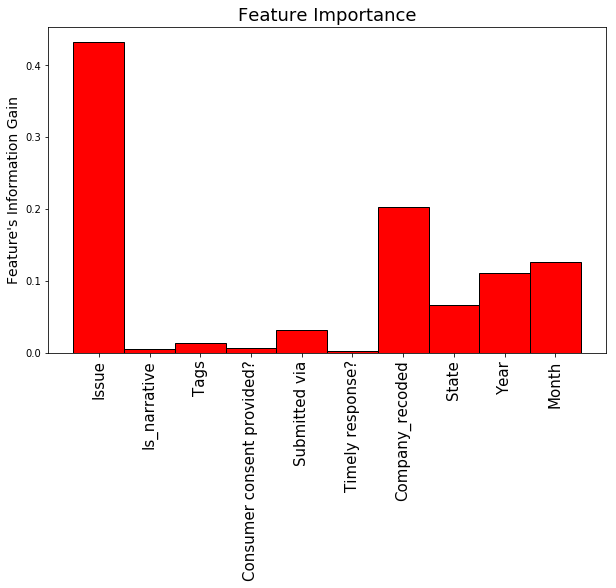

Features by Importance (Information gain or decrease in entropy)


[('Issue', '0.432'),
 ('Company_recoded', '0.203'),
 ('Month', '0.126'),
 ('Year', '0.111'),
 ('State', '0.067'),
 ('Submitted via', '0.032'),
 ('Tags', '0.014'),
 ('Consumer consent provided?', '0.008'),
 ('Is_narrative', '0.005'),
 ('Timely response?', '0.002')]

In [54]:
print("Feature Importance for DT trained on the whole CFPB dataset")
feature_importance(clf, df_encoded[X+['Y']])


The decision tree results show that Issue is indeed a very important predictor of monetary relief, followed by Company, Month, Year, and State. 

Note that variable Issue continues to be the most important predictor in trees with length between 1 and 14. Things start to shift a bit, most likely due to extra noise, when we allow the decision tree grow longer (i.e., overfitting becomes a bigger concern).




**Next,** I drop redundant variables and save the file to be used in the next IPython Notebook, where I run regularized logistic regression.


- As was mentioned above, I decided to keep 'Date received' and drop 'Date sent to company.'


- Whether the consumer disputed the company's resolution is reported in 'Consumer disputed?' variable (Yes/No). Since it captures information that occured following the complaint resolution (post-outcome), it is a so called leakage variable and I drop it. Same for 'Company public response.'


- Drop redundant or re-coded variables such as:

    - 'Sub-product' & 'Sub-issue' (all nulls)
    - 'Complaint ID', 'ZIP code' (not used)
    - 'Product' (one value since we consider credit cards only)
    - 'Issue', 'Company', 'Date received', 'Consumer complaint narrative', 'Tags', 'Consumer   consent provided?', 'Submitted via', 'Timely response?'  (re-coded) 

In [55]:
# Drop redundant or recoded variables
df = df.drop(columns = ['Sub-product', 'Sub-issue', 'Company', 'Issue', 
                        'Complaint ID', 'Product', 'Date sent to company',
                        'Consumer complaint narrative', 'State', 'Tags',
                        'Consumer consent provided?', 'Submitted via',
                        'Date received', 'Year', 'Month', '_merge',
                        'Company_recoded', 'Timely response?',
                        'ZIP code', 'Company public response',
                        'Consumer disputed?'], axis =1)


In [57]:
# Save the final dataset and continue working in the next Ipython Notebook, where I identify
# the best regularized logitistic model
with open(directory+'df.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# to open, use this command:
# df = pd.read_pickle(directory+"df.pickle")

Continue to IPython Notebook #2